In [12]:
#/*
#* Introduction:4 types of data classification
#* Date: March 22,2017
#*/

#import related library
import cPickle
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import SVG
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
from keras.utils import np_utils    
from keras.optimizers import SGD
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,accuracy_score

feature_size = 169
#size of batch for training 169=13*13
batch_size = 128 
#number of classes
num_classes = 5
#total epochs
epochs = 10
#data demission for eacho cell
data_rows, data_cols = 13, 13
input_shape = (data_rows, data_cols, 1)

#column data normalization
def normalize_cols(m):
    col_max = m.max(axis=0) #max value in each column
    col_min = m.min(axis=0) #min value in each column
    return (m-col_min) / (col_max - col_min)

# load original data and label it, random choose 80% as training data, 20% as test_data
def data_prepare():
    dataset1 = np.loadtxt('1.txt',dtype=float) 
    dataset1 = np.nan_to_num(normalize_cols(dataset1))
    label1 = np.ones((len(dataset1),1))            # generate label1
    dataset1 = np.concatenate((dataset1,label1),axis=1)  
    
    dataset2 = np.loadtxt('2.txt',dtype=float)    
    dataset2 = np.nan_to_num(normalize_cols(dataset2))
    label2 = 2*np.ones((len(dataset2),1))          # generate label2
    dataset2 = np.concatenate((dataset2,label2),axis=1)  
    
    dataset3 = np.loadtxt('3.txt',dtype=float)    
    dataset3 = np.nan_to_num(normalize_cols(dataset3))
    label3 = 3*np.ones((len(dataset3),1))          # generate label3
    dataset3 = np.concatenate((dataset3,label3),axis=1)      
        
    dataset4 = np.loadtxt('4.txt',dtype=float)    
    dataset4 = np.nan_to_num(normalize_cols(dataset4))
    label4 = 4*np.ones((len(dataset4),1))          # generate label4
    dataset4 = np.concatenate((dataset4,label4),axis=1)     

    dataset5 = np.loadtxt('5.txt',dtype=float)    
    dataset5 = np.nan_to_num(normalize_cols(dataset5))
    label5 = 5*np.ones((len(dataset5),1))          # generate label5
    dataset5 = np.concatenate((dataset5,label5),axis=1)     
    
    dataset = np.concatenate((dataset1,dataset2,dataset3,dataset4,dataset5,dataset5,dataset5),axis=0)
    random.shuffle(dataset)                       #random shuffle dataset
    return (dataset) 



#split data 8:2 for train and test
def gen_train_test():
    dataset = data_prepare()
    k = int(np.ceil(len(dataset)*0.8))
    end = len(dataset)
    training_data = dataset[0:k,:]        #80% training data
    test_data = dataset[k:end,:]          #20% test data
    return (training_data,test_data)

#load data
def load_data():
    training_data,test_data = gen_train_test()
    X_train = training_data[:,0:feature_size]  #13*13 = 169
    Y_train = training_data[:,171]             #label

    X_test = test_data[:,0:feature_size]
    Y_test = test_data[:,171]
    
    x_train = X_train.reshape(X_train.shape[0], data_rows, data_cols, 1)
    x_test = X_test.reshape(X_test.shape[0], data_rows, data_cols, 1)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    
    # convert class vectors to binary class matrices
    encoder = LabelEncoder()
    encoded_TRY = encoder.fit_transform(Y_train)
    encoded_TEY = encoder.fit_transform(Y_test)
    y_train = np_utils.to_categorical(encoded_TRY, num_classes) #one hot encoding
    y_test = np_utils.to_categorical(encoded_TEY, num_classes)  
    
    return (x_train,x_test,y_train,y_test,Y_test)
    
#build neuro network model
def build_model():
    model = Sequential()
    #convolution layer
    model.add(Conv2D(52, kernel_size=(3, 3), activation='relu', input_shape=input_shape))  
    #max pooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    #full connect layer
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    #full connect layer
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
    return model

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def predict(model, X_test, y_test = None):
    predictions = model.predict(X_test)
    get_class = lambda classes_probabilities: np.argmax(classes_probabilities) + 1
    y_pred = np.array(map(get_class, predictions))
    if y_test is not None:
       y_true = np.array(map(get_class, y_test))
       print accuracy_score(y_true, y_pred)
    return y_pred

def main():
    x_train,x_test,y_train,y_test,Y_test = load_data()
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    
    model = build_model()
    model.summary()
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(x_test, y_test))

    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    #evaluate
    #score = model.evaluate(x_test, y_test, verbose=0)
    #print('Test loss:', score[0])
    #print('Test accuracy:', score[1])
    
    y_pred = predict(model, x_test, y_test)
    print Y_test
    print y_pred

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(Y_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    class_names = [1,2,3,4,5];
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()




/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:41: RuntimeWarning: invalid value encountered in divide


('x_train shape:', (211112, 13, 13, 1))
(211112, 'train samples')
(52777, 'test samples')
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 11, 11, 52)        520       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 52)          0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 5, 5, 52)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1300)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               166528    
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
____________________________________________________

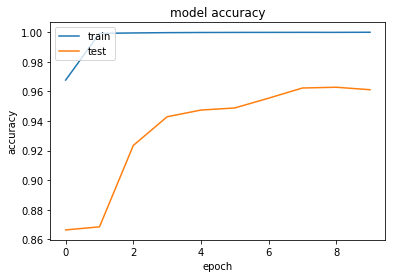

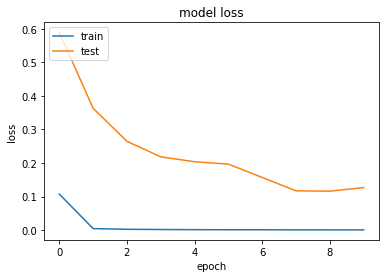

0.961100479375
[ 1.  4.  4. ...,  2.  1.  2.]
[1 4 4 ..., 2 1 2]
Confusion matrix, without normalization
[[10715     0     0     0     0]
 [    0 15563     0     0     0]
 [    1     0  7884     0     0]
 [    0     1     4 11590     0]
 [  229  1753     7    58  4972]]
Normalized confusion matrix
[[  1.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00]
 [  0.00e+00   1.00e+00   0.00e+00   0.00e+00   0.00e+00]
 [  1.27e-04   0.00e+00   1.00e+00   0.00e+00   0.00e+00]
 [  0.00e+00   8.62e-05   3.45e-04   1.00e+00   0.00e+00]
 [  3.26e-02   2.50e-01   9.97e-04   8.26e-03   7.08e-01]]


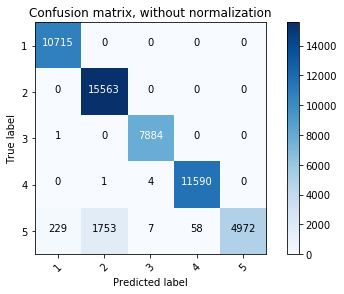

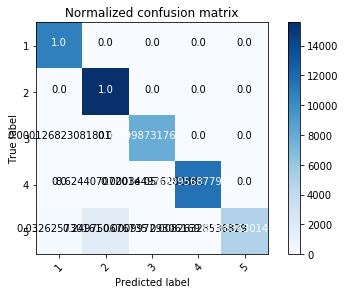

In [13]:
if __name__ == '__main__':
    main()